# DuckDB processing

Query the parquet products and try and make some JSON products from them

Need to get to a format like:  https://github.com/iodepo/odis-arch/blob/master/graphOps/extraction/data/solrexample.json


## Web Loading

In [1]:
import duckdb
import pandas as pd
import numpy as np
import os
import tqdm
from minio import Minio
import matplotlib.pyplot as plt
# import spacy


In [2]:
## load the combined graph
urlCombined = "http://ossapi.oceaninfohub.org/public/assets/combined.parquet"
urlCIOOS = "http://ossapi.oceaninfohub.org/public/assets/cioos.parquet"

duckdb.install_extension("httpfs")

# Instantiate the DuckDB connection
con = duckdb.connect()
con.execute("CREATE TABLE data AS SELECT  row_number() OVER () AS idx, * FROM read_parquet('{}')".format(urlCombined))  # load from url

con2 = duckdb.connect()
con2.execute("CREATE TABLE data AS SELECT  row_number() OVER () AS idx, * FROM read_parquet('{}')".format(urlCIOOS))  # load from url


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
r1 = con.execute("DESCRIBE SELECT * FROM data").fetchdf()
print(list(r1['column_name']))

['idx', 's', 'type', 'name', 'keywords', 'url', 'desc', 'provder', '__index_level_0__']


In [4]:
r2 = con2.execute("DESCRIBE SELECT * FROM data").fetchdf()
print(list(r2['column_name']))

['idx', 'id', 'keywords', 'type', 'name', 'description', 'url', 'geotype', 'geompred', 'geom', 'temporalCoverage', 'datePublished', 'license', 'creator', 'includedInDataCatalog', 'distribution', 'publisher', 'filteredgeom', 'dt_startDate', 'dt_endDate', 'n_startYear', 'n_endYear', 'centroid', 'length', 'area', 'wkt', 'geojson']


In [16]:
# Now you can execute SQL queries on the Parquet file as if it was a regular table
kc = con.execute("SELECT keywords, COUNT(*) AS counts FROM data GROUP BY keywords ORDER BY  counts DESC" ).fetchdf()
kc = kc[kc['keywords'].notna()]
df = kc.head(30)


/tmp/ipykernel_3686125/1023690343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['counts'] = df['counts'] / df['counts'].sum()
/tmp/ipykernel_3686125/1023690343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].apply(lambda x: x[:10] if len(x) > 10 else x)


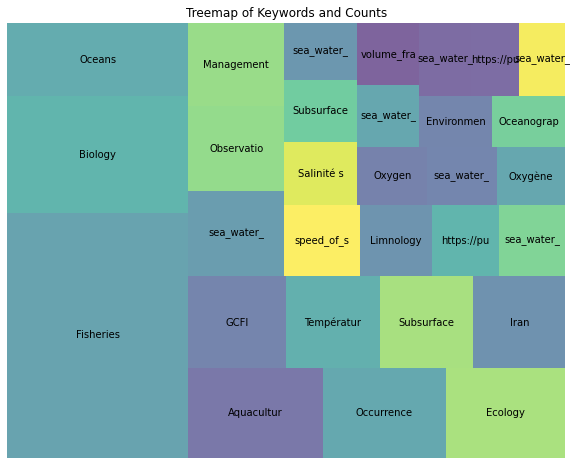

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Normalize the counts to sum up to 1
df['counts'] = df['counts'] / df['counts'].sum()
df['keywords'] = df['keywords'].apply(lambda x: x[:10] if len(x) > 10 else x)

# Create the treemap
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# Squarify the data
squarify.plot(sizes=df['counts'], label=df['keywords'], ax=ax, alpha=0.7)

# Adjust the plot
ax.axis('off')
plt.title('Treemap of Keywords and Counts')

plt.show()

## Load local files

In [10]:
con3 = duckdb.connect()
# dir = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_baseQuery.parquet"
# dir = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_dataset.parquet"
# dir = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*.parquet"
dir = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_sup_geo.parquet"

con3.execute("CREATE TABLE data AS SELECT * FROM read_parquet('{}',  union_by_name = true)".format(dir))  # load from url

In [11]:
r1 = con3.execute("DESCRIBE SELECT * FROM data").fetchdf()
print(list(r1['column_name']))

['id', 'type', 'placename', 'geotype', 'geompred', 'geom', 'lat', 'long', 'g']


In [12]:
kc = con3.execute("SELECT * FROM data" ).fetchdf()

In [13]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26765 entries, 0 to 26764
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         26765 non-null  object
 1   type       26765 non-null  object
 2   placename  0 non-null      object
 3   geotype    26763 non-null  object
 4   geompred   26763 non-null  object
 5   geom       26763 non-null  object
 6   lat        0 non-null      object
 7   long       0 non-null      object
 8   g          26765 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB


In [14]:
# kc = kc[kc['keywords'].notna()]
kc.head()

,id,type,placename,geotype,geompred,geom,lat,long,g
0,https://catalogue.cioos.ca/dataset/1721338f-cc...,https://schema.org/Dataset,NaN,https://schema.org/GeoShape,https://schema.org/box,47.9817231 -70.173161 49.6416261 -67.0137501,NaN,NaN,urn:gleaner.io:iow:cioos:data:94817ccbb6779fc0...
1,https://catalogue.cioos.ca/dataset/ca-cioos_a0...,https://schema.org/Dataset,NaN,https://schema.org/GeoShape,https://schema.org/box,49.83702595 -125.2942704 50.05976151 -124.9057...,NaN,NaN,urn:gleaner.io:iow:cioos:data:cde9511a0e90134f...
2,https://catalogue.cioos.ca/dataset/ca-cioos_17...,https://schema.org/Dataset,NaN,https://schema.org/GeoShape,https://schema.org/box,43.38978964 -131.40081275 53.31525434 -121.838...,NaN,NaN,urn:gleaner.io:iow:cioos:data:2125ea8633506a7d...
3,https://catalogue.cioos.ca/dataset/31f4eeda-d1...,https://schema.org/Dataset,NaN,https://schema.org/GeoShape,https://schema.org/polygon,"{'type': 'Polygon', 'coordinates': [[[-68.5583...",NaN,NaN,urn:gleaner.io:iow:cioos:data:9a168311e789181d...
4,https://catalogue.cioos.ca/dataset/fd3e7a99-af...,https://schema.org/Dataset,NaN,https://schema.org/GeoCoordinates,https://schema.org/latitude,47.31837666666667,NaN,NaN,urn:gleaner.io:iow:cioos:data:388eada7fd7b65d1...


## Schema testing

In [4]:
con4 = duckdb.connect()

In [5]:
con4.execute("CREATE SCHEMA base")
con4.execute("CREATE SCHEMA course")
con4.execute("CREATE SCHEMA dataset")
con4.execute("CREATE SCHEMA person")
con4.execute("CREATE SCHEMA sup_geo")
con4.execute("CREATE SCHEMA sup_time")

In [6]:
base_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_baseQuery.parquet"
course_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_course.parquet"
dataset_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_dataset.parquet"
person_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_person.parquet"
sg_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_sup_geo.parquet"
st_objs = "/home/fils/src/Projects/OIH/odis-arch/graphOps/extraction/mdp/output/*_sup_temporal.parquet"

In [7]:
con4.execute("CREATE TABLE dataset.data (id VARCHAR, type VARCHAR, sameAs VARCHAR, license VARCHAR, citation VARCHAR, keyword VARCHAR, includedInDataCatalog VARCHAR, distribution VARCHAR, region VARCHAR, provider VARCHAR, publisher VARCHAR, creator VARCHAR )")

In [8]:
con4.execute("COPY dataset.data FROM '{}'".format(dataset_objs)) 

In [9]:
con4.execute("CREATE TABLE base.data (id VARCHAR, type VARCHAR, name VARCHAR, url VARCHAR, description VARCHAR, headline VARCHAR, g VARCHAR )")

In [10]:
con4.execute("COPY base.data FROM '{}'".format(base_objs)) 

In [11]:
# con4.execute("CREATE TABLE base.data AS SELECT * FROM read_parquet('{}',  union_by_name=True)".format(base_objs)) 
con4.execute("CREATE TABLE course.data AS SELECT * FROM read_parquet('{}',  union_by_name=true)".format(course_objs)) 
# con4.execute("CREATE TABLE dataset.data AS SELECT * FROM read_parquet('{}',  union_by_name=true)".format(dataset_objs)) 
con4.execute("CREATE TABLE person.data AS SELECT * FROM read_parquet('{}',  union_by_name=true)".format(person_objs)) 
con4.execute("CREATE TABLE sup_geo.data AS SELECT * FROM read_parquet('{}',  union_by_name=true)".format(sg_objs)) 
con4.execute("CREATE TABLE sup_time.data AS SELECT * FROM read_parquet('{}',  union_by_name=true)".format(st_objs)) 

In [12]:
kc = con4.execute("SELECT * FROM dataset.data" ).fetchdf()
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771462 entries, 0 to 1771461
Data columns (total 12 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     object
 1   type                   object
 2   sameAs                 object
 3   license                object
 4   citation               object
 5   keyword                object
 6   includedInDataCatalog  object
 7   distribution           object
 8   region                 object
 9   provider               object
 10  publisher              object
 11  creator                object
dtypes: object(12)
memory usage: 162.2+ MB


In [13]:
kc.head()

,id,type,sameAs,license,citation,keyword,includedInDataCatalog,distribution,region,provider,publisher,creator
0,https://catalogue.cioos.ca/dataset/37a33ad6-82...,https://schema.org/Dataset,None,None,None,Oceans,http://ckan.onc.uvic.ca,https://catalogue.cioos.ca/dataset/37a33ad6-82...,None,https://cioospacific.ca,https://catalogue.cioos.ca/organization/f6f187...,https://gleaner.io/xid/genid/cog3q93k59mc739rh7ng
1,https://catalogue.cioos.ca/dataset/37a33ad6-82...,https://schema.org/Dataset,None,None,None,Oceans,http://ckan.onc.uvic.ca,https://catalogue.cioos.ca/dataset/37a33ad6-82...,None,https://cioospacific.ca,https://catalogue.cioos.ca/organization/f6f187...,https://gleaner.io/xid/genid/cog3q93k59mc739rh7ng
2,https://catalogue.cioos.ca/dataset/37a33ad6-82...,https://schema.org/Dataset,None,None,None,Oceans,https://catalogue.cioos.ca,https://catalogue.cioos.ca/dataset/37a33ad6-82...,None,https://cioospacific.ca,https://catalogue.cioos.ca/organization/f6f187...,https://gleaner.io/xid/genid/cog3q93k59mc739rh7ng
3,https://catalogue.cioos.ca/dataset/37a33ad6-82...,https://schema.org/Dataset,None,None,None,Oceans,https://catalogue.cioos.ca,https://catalogue.cioos.ca/dataset/37a33ad6-82...,None,https://cioospacific.ca,https://catalogue.cioos.ca/organization/f6f187...,https://gleaner.io/xid/genid/cog3q93k59mc739rh7ng
4,https://catalogue.cioos.ca/dataset/37a33ad6-82...,https://schema.org/Dataset,None,None,None,Oceans,https://catalogue.cioospacific.ca,https://catalogue.cioos.ca/dataset/37a33ad6-82...,None,https://cioospacific.ca,https://catalogue.cioos.ca/organization/f6f187...,https://gleaner.io/xid/genid/cog3q93k59mc739rh7ng


# The following was imported from another notebook, so it might have some run issues.


In [ ]:
# OIH Dashboard pre-processor query

This notebook demonstrates query approach for the pre-processed resources from the OIH Graph


In [ ]:
import duckdb

## Pre-processed OIH Graph

In [ ]:
## load the combined graph
url = "http://ossapi.oceaninfohub.org/public/combined.parquet"
duckdb.install_extension("httpfs")

# Instantiate the DuckDB connection
con = duckdb.connect()
# con.execute("CREATE TABLE my_table AS SELECT * FROM read_parquet('{}')".format(url))  # load from url
con.execute("CREATE TABLE my_table AS SELECT * FROM read_parquet('../../secret/combined.parquet')") # load from local parquet


In [ ]:

# Now you can execute SQL queries on the Parquet file as if it was a regular table
# r = con.execute("SELECT DISTINCT provder FROM my_table").fetchdf()
# r = con.execute(" SELECT DISTINCT provder, type, ANY_VALUE(s),  COUNT(*) AS count FROM my_table GROUP BY provder, type  order by count desc").fetchdf()
r = con.execute(" SELECT DISTINCT provder, type, COUNT(*) AS count FROM my_table GROUP BY provder, type").fetchdf()

print(r)


In [ ]:
r = con.execute(" SELECT keywords, COUNT(*) AS count FROM my_table WHERE keywords <> 'NaN' GROUP BY keywords order by count desc").fetchdf()
print(r)


In [ ]:
r = con.execute(" SELECT SUM(count) AS total_count FROM ( SELECT DISTINCT keywords, COUNT(*) AS count FROM my_table WHERE keywords <> 'NaN' GROUP BY keywords order by count desc) AS counts").fetchdf()
print(r)

In [ ]:
r = con.execute(" SELECT type, COUNT(*) AS count FROM my_table GROUP BY type order by count desc").fetchdf()
print(r)

## graph parquet


In [ ]:
url = "http://ossapi.oceaninfohub.org/public/oihgraph_rdf.parquet"
duckdb.install_extension("httpfs")

# Instantiate the DuckDB connection
con2 = duckdb.connect()
# con.execute("CREATE TABLE my_table AS SELECT * FROM read_parquet('{}')".format(url))  # load from url
con2.execute("CREATE TABLE my_table AS SELECT * FROM read_parquet('../../secret/oihgraph_rdf.parquet')") # load from local parquet



In [ ]:

r = con2.execute(" SELECT DISTINCT predicate,  COUNT(*) AS count FROM my_table GROUP BY predicate order by count desc").fetchdf()
print(r)